In [1]:
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np

In [2]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(size=5, shift=1, drop_remainder=True)

In [14]:
list(dataset)

[<_VariantDataset shapes: (), types: tf.int64>,
 <_VariantDataset shapes: (), types: tf.int64>,
 <_VariantDataset shapes: (), types: tf.int64>,
 <_VariantDataset shapes: (), types: tf.int64>,
 <_VariantDataset shapes: (), types: tf.int64>,
 <_VariantDataset shapes: (), types: tf.int64>]

In [18]:
type(dataset)

tensorflow.python.data.ops.dataset_ops.WindowDataset

In [20]:
list(dataset.flat_map(lambda window: window.batch(5)))

[<tf.Tensor: shape=(5,), dtype=int64, numpy=array([0, 1, 2, 3, 4], dtype=int64)>,
 <tf.Tensor: shape=(5,), dtype=int64, numpy=array([1, 2, 3, 4, 5], dtype=int64)>,
 <tf.Tensor: shape=(5,), dtype=int64, numpy=array([2, 3, 4, 5, 6], dtype=int64)>,
 <tf.Tensor: shape=(5,), dtype=int64, numpy=array([3, 4, 5, 6, 7], dtype=int64)>,
 <tf.Tensor: shape=(5,), dtype=int64, numpy=array([4, 5, 6, 7, 8], dtype=int64)>,
 <tf.Tensor: shape=(5,), dtype=int64, numpy=array([5, 6, 7, 8, 9], dtype=int64)>]

In [21]:
type(dataset.flat_map(lambda window: window.batch(5)))

tensorflow.python.data.ops.dataset_ops.FlatMapDataset

In [ ]:
dataset = dataset.flat_map(lambda window: window.batch(5))

In [24]:
list(dataset.map(lambda window: (window[:-1], window[-1])))

[(<tf.Tensor: shape=(4,), dtype=int64, numpy=array([0, 1, 2, 3], dtype=int64)>,
  <tf.Tensor: shape=(), dtype=int64, numpy=4>),
 (<tf.Tensor: shape=(4,), dtype=int64, numpy=array([1, 2, 3, 4], dtype=int64)>,
  <tf.Tensor: shape=(), dtype=int64, numpy=5>),
 (<tf.Tensor: shape=(4,), dtype=int64, numpy=array([2, 3, 4, 5], dtype=int64)>,
  <tf.Tensor: shape=(), dtype=int64, numpy=6>),
 (<tf.Tensor: shape=(4,), dtype=int64, numpy=array([3, 4, 5, 6], dtype=int64)>,
  <tf.Tensor: shape=(), dtype=int64, numpy=7>),
 (<tf.Tensor: shape=(4,), dtype=int64, numpy=array([4, 5, 6, 7], dtype=int64)>,
  <tf.Tensor: shape=(), dtype=int64, numpy=8>),
 (<tf.Tensor: shape=(4,), dtype=int64, numpy=array([5, 6, 7, 8], dtype=int64)>,
  <tf.Tensor: shape=(), dtype=int64, numpy=9>)]

In [27]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(size=5, shift=1, drop_remainder=True)
# Use flat_map if you want to make sure that the order of your dataset stays the same.
dataset = dataset.flat_map(lambda window: window.batch(5))
# create the input and label
dataset = dataset.map(lambda window: (window[:-1], window[-1]))
# shuffle, buffer_size=> number of samples will be shuffle
dataset = dataset.shuffle(buffer_size=10)
# create the batch to train
dataset = dataset.batch(batch_size=2).prefetch(2)

In [28]:
for (x, y) in dataset:
    print(x.numpy(), y.numpy())

[[1 2 3 4]
 [0 1 2 3]] [5 4]
[[5 6 7 8]
 [2 3 4 5]] [9 6]
[[4 5 6 7]
 [3 4 5 6]] [8 7]


In [29]:
type(dataset)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

# Windows dataset

In [33]:
def windows_dataset(series, window_size, batch_size, shuffle_buffer):
    # Forces the data tensorflow type
    # create a dataset from the series using a tf.data dataset
    dataset = tf.data.Dataset.from_tensor_slices(series)
    # Each "window" is a dataset that contains a subset of elements of the input dataset.
    dataset = dataset.window(size=window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    # Shuffle dataset
    dataset = dataset.shuffle(buffer_size=shuffle_buffer)
    # Create a pair of train and label data
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    # Create the batch size
    dataset = dataset.batch(batch_size)
    # Reduce the time training, it will prefetch two elements in next batch
    dataset = dataset.prefetch(1)
    return dataset


# Slit dataset into training and validation sets

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [3]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [7]:
# Simple model

dataset = windows_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)

print("Layer weights {}".format(l0.get_weights()))


<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>
Layer weights [array([[-0.068453  ],
       [ 0.00915169],
       [ 0.02362942],
       [ 0.03707773],
       [ 0.04835501],
       [-0.02250461],
       [-0.06280438],
       [-0.02446119],
       [ 0.04097927],
       [ 0.02317762],
       [-0.04258168],
       [ 0.0671417 ],
       [-0.10240595],
       [ 0.11390244],
       [-0.05705515],
       [ 0.07376363],
       [ 0.02106654],
       [ 0.20400006],
       [ 0.21644592],
       [ 0.47162104]], dtype=float32), array([0.01435232], dtype=float32)]


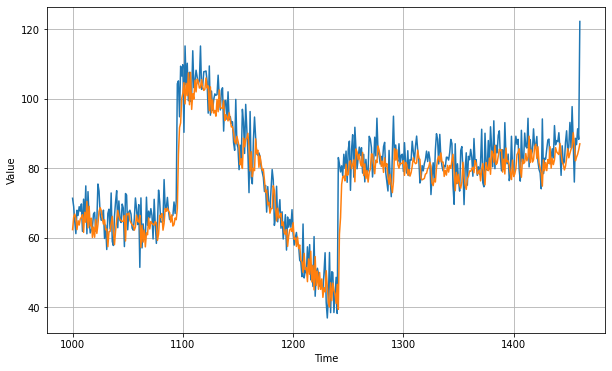

In [8]:
# prediction
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [9]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.25094

# Deep neural network training, tuning and prediction

In [34]:
dataset = windows_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [35]:
dataset

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>

In [36]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epochs: 1e-8 * 10**(epochs / 20)
)

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=7e-8, momentum=0.9))
history = model.fit(dataset, epochs=500, verbose=0)

In [30]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epochs: 1e-8 * 10**(epochs / 20)
)

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=7e-8, momentum=0.9))
history = model.fit(dataset, epochs=500, verbose=0)

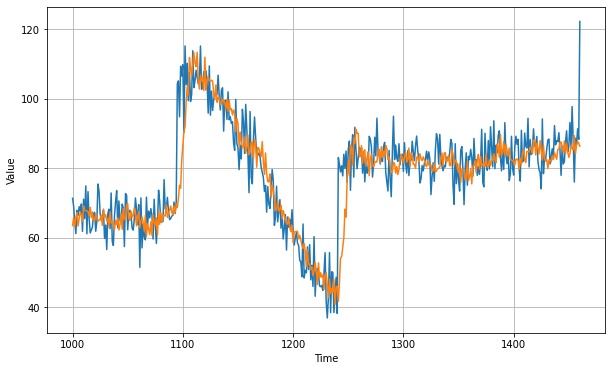

In [37]:
# prediction
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

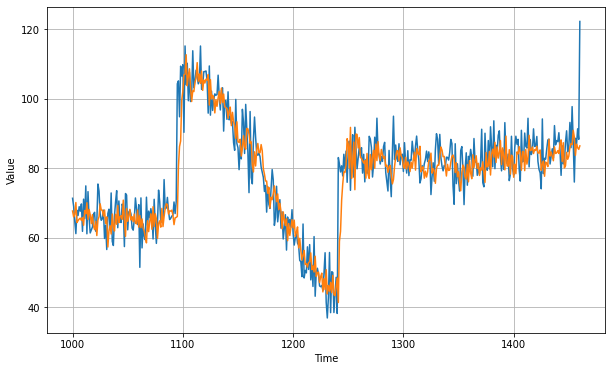

In [31]:
# prediction
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [38]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.382342

In [32]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.190709